Epoch 0, Accuracy: 0.0000, Reward: 0.0157, Epsilon: 1.0000
Epoch 10, Accuracy: 0.5000, Reward: 0.3419, Epsilon: 1.0000
Epoch 20, Accuracy: 0.4706, Reward: 1.1509, Epsilon: 1.0000
Epoch 30, Accuracy: 0.6765, Reward: 4.0434, Epsilon: 1.0000
Epoch 40, Accuracy: 0.6176, Reward: 5.7391, Epsilon: 0.9511
Epoch 50, Accuracy: 0.6471, Reward: 5.6317, Epsilon: 0.9046
Epoch 60, Accuracy: 0.7059, Reward: 4.8024, Epsilon: 0.8604
Epoch 70, Accuracy: 0.7353, Reward: 4.8518, Epsilon: 0.8183
Epoch 80, Accuracy: 0.7059, Reward: 3.7372, Epsilon: 0.7783
Epoch 90, Accuracy: 0.7647, Reward: 2.8951, Epsilon: 0.7403


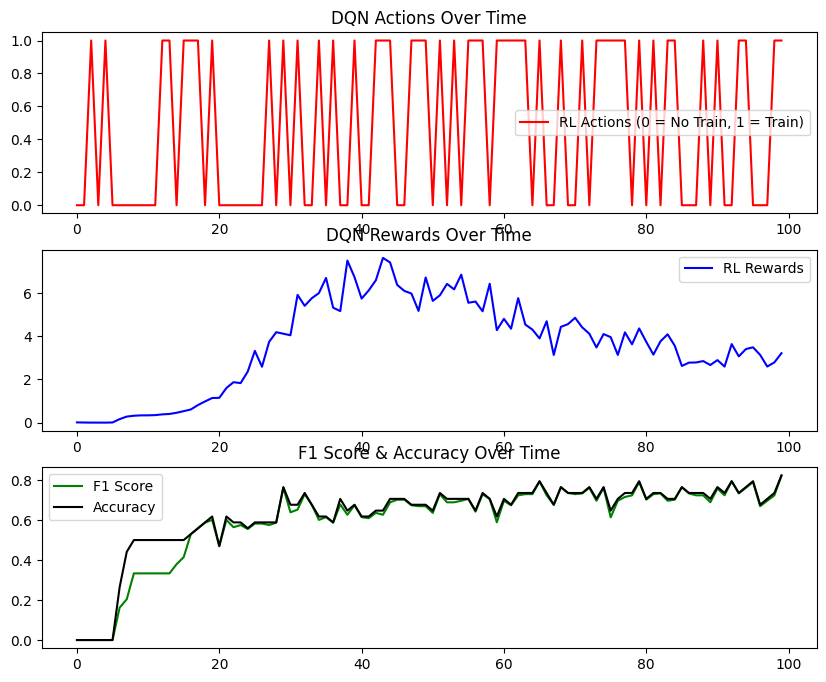

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
from sklearn.metrics import f1_score, accuracy_score

# ✅ 1. 生成动态 Karate Club 数据集
def create_dynamic_graph():
    G = nx.karate_club_graph()
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    num_nodes = G.number_of_nodes()
    x = torch.eye(num_nodes)  # 单位矩阵作为特征
    labels = torch.randint(0, 2, (num_nodes,))  # 二分类标签
    return G, Data(x=x, edge_index=edge_index, y=labels)

G, dataset = create_dynamic_graph()

# ✅ 2. GCN 模型（加入 Dropout 和 L2 正则化）
class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_classes=8, dropout=0.3):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_features)
        self.conv2 = GCNConv(hidden_features, out_features)
        self.fc = torch.nn.Linear(out_features, num_classes)
        self.dropout = dropout  # ✅ 加入 Dropout 层

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # ✅ Dropout 防止过拟合
        x = self.conv2(x, edge_index)
        x = self.fc(x)  
        return x

# ✅ 3. DQN 代理（优化 Q-learning 公式）
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.01, gamma=0.9, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon  # 初始探索率
        self.epsilon_min = epsilon_min  # 最低探索率
        self.epsilon_decay = epsilon_decay  # 逐渐减少探索
        self.memory = deque(maxlen=1000)
        self.model = self._build_model()

    def _build_model(self):
        return torch.nn.Sequential(
            torch.nn.Linear(self.state_size, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.action_size)
        )

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float).view(1, -1)
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.action_size))
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        batch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in batch:
            state = torch.tensor(state, dtype=torch.float).view(1, -1)
            next_state = torch.tensor(next_state, dtype=torch.float).view(1, -1)

            target = reward
            if not done:
                target += self.gamma * torch.max(self.model(next_state)).item()

            q_values = self.model(state)
            q_values = q_values.clone().detach()
            # q_values[0, action] = target
            q_values[0, action] = torch.tensor(target, dtype=torch.float32)


            loss = F.mse_loss(q_values, self.model(state))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ✅ 每次训练后，降低探索率，防止 DQN 过度自信
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ✅ 4. 修改动态图扰动（加入噪声）
def modify_graph(G, dataset, action):
    edge_list = list(G.edges)
    num_changes = 3  
    if action == 1:  
        for _ in range(num_changes):
            u, v = random.sample(range(G.number_of_nodes()), 2)
            G.add_edge(u, v)
    else:  
        if len(edge_list) > num_changes:
            edges_to_remove = random.sample(edge_list, num_changes)
            for u, v in edges_to_remove:
                G.remove_edge(u, v)

    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    dataset.edge_index = edge_index
    return dataset

# ✅ 5. 训练 GNN + DQN（论文中的 Reward Function）
action_history, reward_history = [], []
f1_history, accuracy_history = [], []

def train(gnn, agent, dataset, epochs=100):
    optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01, weight_decay=0.01)  # ✅ 加入 L2 正则化
    for epoch in range(epochs):
        logits = gnn(dataset)

        state = logits.detach().mean(dim=0).view(1, -1).numpy()
        action = agent.act(state)

        predictions = torch.argmax(logits, dim=1)
        y_true = dataset.y.numpy()
        y_pred = predictions.detach().numpy()
        accuracy = accuracy_score(y_true, y_pred)

        # ✅ 计算 Stability（论文中的稳定性公式）
        stability = np.var(logits.detach().numpy())  

        # ✅ 计算 Update Cost（论文中的更新代价）
        update_cost = 0.1 if action == 1 else 0.05  

        # ✅ 论文中的最终奖励公式
        reward = (0.6 * accuracy) + (0.3 * stability) - (0.1 * update_cost)  

        action_history.append(action)
        reward_history.append(reward)
        f1_history.append(f1_score(y_true, y_pred, average='macro'))
        accuracy_history.append(accuracy)

        next_state = state + np.random.normal(0, 0.1, state.shape)
        agent.remember(state, action, reward, next_state, done=False)

        optimizer.zero_grad()
        loss = F.cross_entropy(logits, dataset.y)
        loss.backward()
        optimizer.step()

        agent.replay(batch_size=32)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Accuracy: {accuracy:.4f}, Reward: {reward:.4f}, Epsilon: {agent.epsilon:.4f}")

# ✅ 6. 运行训练（修正 state_size=8）
gnn = GCN(in_features=dataset.num_nodes, hidden_features=16, out_features=8, num_classes=8)
agent = DQNAgent(state_size=8, action_size=2)
train(gnn, agent, dataset)


# ✅ 6. 结果可视化
plt.ion()
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

def update_plot():
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()

    ax[0].plot(action_history, 'r-', label="RL Actions (0 = No Train, 1 = Train)")
    ax[1].plot(reward_history, 'b-', label="RL Rewards")
    ax[2].plot(f1_history, 'g-', label="F1 Score")
    ax[2].plot(accuracy_history, 'k-', label="Accuracy")

    ax[0].set_title("DQN Actions Over Time")
    ax[1].set_title("DQN Rewards Over Time")
    ax[2].set_title("F1 Score & Accuracy Over Time")

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    plt.pause(0.01)

for _ in range(100):
    update_plot()

plt.ioff()
plt.show()